In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Oversampling
from imblearn.over_sampling import SMOTE

#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Grilla de búsqueda de mejores hiperparámetros
from sklearn.model_selection import GridSearchCV

# Métricas
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

# Serialización de archivos
import pickle

In [2]:
auxiliares_path = os.path.abspath(os.path.join('..'))
if auxiliares_path not in sys.path:
    sys.path.append(auxiliares_path+'\\auxiliares')

#Importando funciones auxiliares    
import auxiliares.helpers as hp
import auxiliares.preproc_nyc_sqf as preproc

# 1. Ingesta de data y análisis de esta

In [3]:
df_2009 = pd.read_csv('datasets/2009_1perc.csv').drop('Unnamed: 0', axis=1)
df_2010 = pd.read_csv('datasets/2010_1perc.csv').drop('Unnamed: 0', axis=1)

In [4]:
df_2009.head(3)

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2009,41,1779,4032009,130,A,O,P,1.0,CPW,...,,41,G,7,,1013067,0238633,CM,1,20
1,2009,108,5805,10292009,1050,A,O,P,3.0,BURG,...,,108,J,,,1012043,0212157,CM,1,14
2,2009,43,8340,10062009,1450,1,O,P,1.0,MISD,...,,43,E,,,1017599,0240200,CM,1,20


In [5]:
df_2010.head(3)

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2010,6,487,1192010,1420,1,O,P,2,FEL,...,,6,G,,38,983543,208767,CM,1,85
1,2010,42,7138,9042010,225,1,I,T,10,FELONY,...,,42,E,,,1014172,241737,CM,1,45
2,2010,33,2628,6302010,1240,1,I,T,5,ROBBERY,...,,33,B,6,,1000916,245710,CM,1,85


In [6]:
print(f'datos 2009: {df_2009.shape[1]} columnas y {df_2009.shape[0]} datos')
print(f'datos 2010: {df_2010.shape[1]} columnas y {df_2010.shape[0]} datos')


datos 2009: 111 columnas y 5812 datos
datos 2010: 111 columnas y 6013 datos


Los datos de ambos DataFrames tienen 111 columnas, que lo más probable que no todas sean de utilidad, además algunas columnas como 'beat' o 'post' tienen registros con datos faltantes, en formato de espacios. Veremos más a profundidad estos datos faltantes.

In [7]:
df_2009_nan = df_2009.replace(' ', np.nan)
df_2010_nan = df_2010.replace(' ', np.nan)

In [8]:
df_2009_nan.isna().sum().sort_values(ascending=False)[:23]

aptnum      5812
othfeatr    5812
rescode     5812
premtype    5812
zip         5812
state       5812
officrid    5727
arstoffn    5464
sumoffen    5456
post        5268
offverb     4559
offshld     4205
beat        3622
addrnum     3300
stname      3225
premname     591
trhsloc      205
xcoord       168
ycoord       168
sector       116
stinter       40
crossst       40
cs_other       0
dtype: int64

Como podemos ver en la lista de arriba, se aprecia que hay 22 columnas con valores perdidos, pero lo interesante es en cuanto a la cantidad de datos perdidos, se puede apreciar que desde "aptnum" a "stname" pasan de 5.812 a 3.225 datos perdidos respectivamente, despues baja drásticamente a 591 con "premname" y siguen siendo menos los datos perdidos.

Lo interesante es que estos datos perdidos hay que tratarlos, pero contamos con una función auxiliar que hace este trabajo, de imputar valores en algunas columnas, según algunos criterios ahí definidos, además de reglas como por ejemplo que la edad de la persona esté entre 18 y 100 años, de modo que si viola esta regla, le asigna valos np.nan, eliminando estos registros posteriormente (No deberían poder controlar gente menor de edad y si tiene más de 100 años es muy probable que sea un error de tipeo).

In [9]:
df_consolidado = pd.concat([df_2009.set_index(df_2009['year']), 
                            df_2010.set_index(df_2010['year'])])

In [10]:
df_procesado, a, b = preproc.create_suitable_dataframe(df_consolidado)

['perobs']


In [11]:
#Guardamos el archivo ya procesado en un CSV.
df_procesado.to_csv('stop_and_frisk.csv')

# 2. Análisis Exploratorio

## 2.1. Comportamiento de Vector objetivo 'arstmade'.

In [12]:
df_procesado['arstmade'].value_counts('%')*100

N    93.712032
Y     6.287968
Name: arstmade, dtype: float64

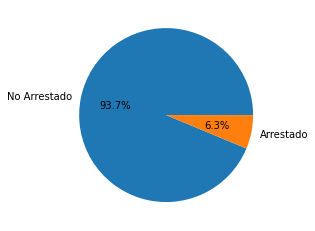

In [13]:
fig, ax = plt.subplots()
labels = ['No Arrestado', 'Arrestado']
sizes = [df_procesado['arstmade'].value_counts('%')[0]*100, df_procesado['arstmade'].value_counts('%')[1]*100]
ax.pie(sizes, labels = labels, autopct='%1.1f%%');
plt.show()

De todas las personas controladas aproximadamente un 6.3% fueron arrestadas

***¿De qué ciudad provienenestos registros?***

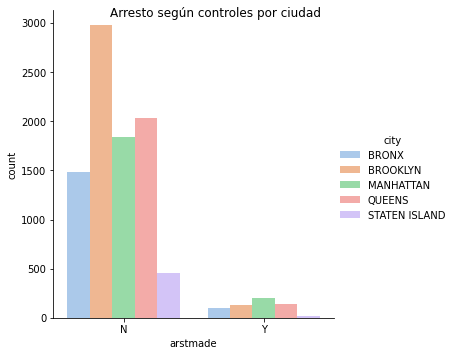

In [99]:
g = sns.catplot(data = df_procesado, x = 'arstmade', hue = 'city', kind = 'count', palette = 'pastel')
g.fig.suptitle('Arresto según controles por ciudad')
plt.savefig('imagenes/Arresto_por_ciudad.jpg')

In [15]:
df_procesado.groupby('city')['arstmade'].value_counts()

city           arstmade
BRONX          N           1480
               Y            100
BROOKLYN       N           2979
               Y            132
MANHATTAN      N           1844
               Y            197
QUEENS         N           2038
               Y            142
STATEN IS      N            217
               Y              9
STATEN ISLAND  N            235
               Y             10
Name: arstmade, dtype: int64

De los controles realizados por ciudad, se puede obtener la siguiente información:
* La mayor cantidad de controles se realizaron en ***Brooklyn y Queens*** y la ciudad que menos controles tuvo, fue ***Staten Island***.
* Hay un country llamado ***STATEN IS***, que es lo mismo que *STATEN ISLAND*, por lo cual hay que corregirlo.

***¿Qué podemos decir en cuanto a la raza y el sexo de las personas que fueron controladas?***

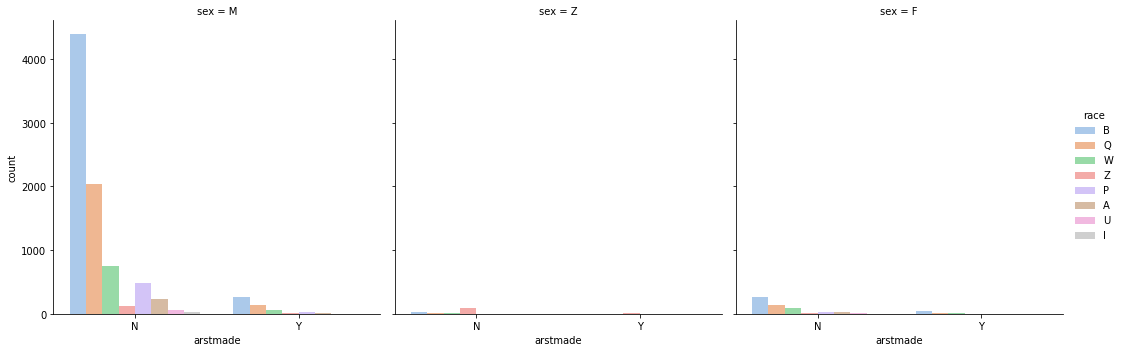

In [16]:
sns.catplot(data = df_procesado, x='arstmade', hue='race', col='sex', kind='count', palette='pastel')

* Del total de personas que son **controladas**, la mayoría son de raza ***Negra*** e ***Hispanos blancos***, seguidas de ***Hispanos negros***, ya muy por debajo se encuentras todas las demás razas, resaltando también aunque minoritaria, el control a ***Blancos*** e ***Hispanos negros***.
* Pasando ahora a los que son **arrestados**, nos encontramos con el mismo panorama, se detienen principalmente a personas de raza ***Negra*** e ***Hispanos blancos***.

Ya con estos antecedentes, podemos ver una clara tendencia de que los datos recopilados están sesgados de una forma racista, no se controla a la gente por igual, tienen una clara tendencia a controlar a personas negras e hispanas, por lo que probablemente los resultados de los modelos que puedan salir de analizar esta información, sean también sesgado. Por lo que tendremos que tener mucho cuidado en la ética del análisis que realizemos.

**Por último, ¿qué tipo de datos tenemos?**

In [17]:
df_procesado.dtypes.value_counts()

object     74
int64       1
float64     1
dtype: int64

In [18]:
df_procesado.dtypes.value_counts('%')*100

object     97.368421
int64       1.315789
float64     1.315789
dtype: float64

El 95.3% de los atributos del dataset son variables categóricas, a pesar de que se pueden tratar para pasarlas a valores numéricos, para que puedan ser usadas en los modelos de machine learning, son demasiados valores categóricos, por lo que veremos finalmente si los resultados obtenidos son de buena calidad, para tener conclusiones de peso.

# 3. Feature Engieneering

In [19]:
for i in df_procesado.columns:
    if df_procesado[i].unique().shape[0] < 2:
        print(i, df_procesado[i].unique().shape[0])

addrtyp 1
dettypcm 1


In [20]:
df_procesado['linecm'].unique()

array([1, '1'], dtype=object)

In [21]:
df_procesado.drop(columns = ['addrtyp', 'dettypcm', 'linecm'], axis=1, inplace=True)

Eliminamos las siguientes variables, por tener sólo un tipo de dato y no brindar información:
* ***addrtyp***
* ***dettypcm*** 
* ***linecm***

***¿Cuales atributos tienen más de 2 valores únicos?***

In [22]:
for i in df_procesado.columns:
    if df_procesado[i].unique().shape[0] > 2:
        print(i, df_procesado[i].unique().shape[0])

trhsloc 4
typeofid 4
sex 3
race 8
haircolr 11
eyecolor 11
build 5
city 6
sector 18
beat 63
month 12
meters 30


In [23]:
df_procesado.city.value_counts()

BROOKLYN         3111
QUEENS           2180
MANHATTAN        2041
BRONX            1580
STATEN ISLAND     245
STATEN IS         226
Name: city, dtype: int64

Modificamos el valor de ***STATEN IS***, para que sea ***STATEN ISLAND***

In [24]:
df_procesado['city'].replace(to_replace='STATEN IS', value='STATEN ISLAND', inplace=True)

In [25]:
df_procesado['beat'].value_counts('%')*100

U       63.103485
9        3.495684
1        2.749654
7        2.579132
4        2.344666
          ...    
30       0.010658
  25     0.010658
26       0.010658
  61     0.010658
  42     0.010658
Name: beat, Length: 63, dtype: float64

In [26]:
df_procesado.drop(columns=['beat'], axis=1, inplace=True)

Eliminamos  ***beat*** por tener 63 valores diferentes y un 63% de ellos son valores desconocidos, por lo que no aporta información relevante.

***¿Qué sucede con las columnas que comienzan con "pf_"?***

Sucede que todas esas columnas hacen alusión a un tipo de detención usando fuerza física por parte del oficial, por lo cual los uniremos en una categoría llamada ***violent_arrest***, en donde si un detención tiene presente al menos uno de estos factores, será catalogado como violento.

De esta manera podremos eliminar todas estas columnas, para dejar presente sólo la detención violenta.

In [27]:
df_procesado['violent_arrest'] = np.select([df_procesado['pf_hands'] == 'Y', df_procesado['pf_wall'] == 'Y', df_procesado['pf_grnd']  == 'Y', 
                                          df_procesado['pf_drwep'] == 'Y' , df_procesado['pf_ptwep'] == 'Y' , df_procesado['pf_baton'] == 'Y',
                                          df_procesado['pf_hcuff'] == 'Y' , df_procesado['pf_pepsp'] == 'Y', df_procesado['pf_other'] == 'Y'],
                                          [1, 1, 1, 1, 1, 1, 1, 1, 1], 0)

In [28]:
df_procesado.drop(columns = ['pf_hands', 'pf_wall', 'pf_grnd', 'pf_drwep',
                            'pf_ptwep', 'pf_baton', 'pf_hcuff', 'pf_pepsp',
                            'pf_other'], inplace = True)

0    76.084408
1    23.915592
Name: violent_arrest, dtype: float64

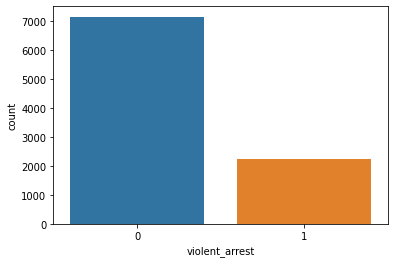

In [29]:
sns.countplot(data=df_procesado, x='violent_arrest')
df_procesado['violent_arrest'].value_counts('%')*100

Del total de controles realizados, un 23.9% de ellos fueron realizados por el oficial utilizando fuerza física.

En otras palabras 1 de cada 4 controles fueron realizados de forma violenta por los oficiales.

## 3.1. Binarización de datos

Debido a que los modelos de machine learning no funcionan con valores categóricos, es necesario recodificarlos de alguna manera, para que estos puedan quedar en formato numérico, ahora utilizaré la función de la librería *pandas* 'get_dummies' la que convierte las variables categóricas en variables dummies en donde toman el valor de 1 si cumplen la condición de la columna y 0 si no.

In [30]:
var_categoricas = []
for i in df_procesado:
    if df_procesado[i].dtype == object:
        var_categoricas.append(i)

In [31]:
df_binarizado = hp.binarizar(df_procesado, var_categoricas)

In [32]:
df_binarizado.head(5)

,month,meters,violent_arrest,recstat_1,inout_I,trhsloc_H,trhsloc_T,trhsloc_U,typeofid_O,typeofid_R,...,sector_I,sector_J,sector_K,sector_M,sector_N,sector_P,sector_Q,sector_R,sector_T,sector_U
year,,,,,,,,,,,,,,,,,,,,,
2009,4,1.798320,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,10,1.920240,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,12,1.676400,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2009,5,1.767840,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,11,1.557528,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## 3.2. Separación de datos.

Los datos del año 2009 serán utilizados para el entrenamiento y los del año 2010 lo usaremos para para validación.

Nuestros vectores objetivos serán dos:
* ***arstmade_Y***: Si el control terminó en un arresto.
* ***violent_arrest***: Si el control fué violento (el oficial utilizó fuerza física).

In [33]:
# Entrenamiento
df_train = df_binarizado.query('year==2009')
X_train_arstmade = df_train.drop(columns = ['arstmade_Y'])
y_train_arstmade = df_train['arstmade_Y']

X_train_violent = df_train.drop(columns = ['violent_arrest'])
y_train_violent = df_train['violent_arrest']

# Testeo
df_test = df_binarizado.query('year==2010')
X_test_arstmade = df_test.drop(columns = ['arstmade_Y'])
y_test_arstmade = df_test['arstmade_Y']

X_test_violent = df_test.drop(columns = ['violent_arrest'])
y_test_violent = df_test['violent_arrest']

In [34]:
df_test.columns.difference(df_train.columns)

Index([], dtype='object')

No hay diferencias entre los datos de entrenamiento y testeo, por lo cual ya estamos listos para comenzar a modelar.

# 4. Modelación

Antes de modelar, cabe preguntarnos qué métricas de evaluación, serán las más relevante para estos problemas, dado que estamos clasificando detenciones que terminan en arrestos, como también detenciones que tengan violencia, y además las clases están desbalanceadas, el **accuracy** no es una buena medida de evaluación, ya que lo más interesante a clasificar es cuando la clase tendrá el valor de 1 (hubo un arresto o fue violento el arresto), y al estar desbalanceado el problema, generalmente clasifica de manera muy buena la clase con mayores ocurrencias (clase 0) y mal la con menos ocurrencia (clase 1), por lo que el accuracy no nos dice mucho.

Por otro lado la **métrica más relevante** para estos casos, es la **precision**, ya que lo que queremos es capturar de buena manera los True Positive, y además el costo de un falso positivo es alto (decir que un control resultará en arresto, cuando no debería serlo), ya que se estará de cierta forma inculpando de manera injustificada a la persona controlada.

## 4.1. Grilla de búsqueda oversampling.

A continuación están la grillas de hiperparámetros que se usarán.

In [35]:
grid_params_NB = [{'alpha' : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
                  }]

## 4.2. ¿Realizamos Oversampling?

Nuestros dos vectores objetivos están desbalanceados, los problemas de clasificación con clases desbalanceadas crea un sesgo en los modelos de machine learning, en donde a veces tienden a predecir la clase mayoritaria. 

* arstmade: 6.3%
* violent_arrest: 23.9%

Probaremos con el algoritmo Neive Bayes clasificar con y sin la técnica de Oversampling, a través de SMOTE y veremos que resultados arroja.

In [36]:
# Instanciamos la clase
oversampler = SMOTE(random_state = 3214, sampling_strategy = 'minority')
# Generamos el oversampling de la matriz de entrenamiento
X_train_oversamp_violent, y_train_oversamp_violent = oversampler.fit_resample(X_train_violent, y_train_violent)

# Generamos el oversampling de la matriz de entrenamiento
X_train_oversamp_arstmade, y_train_oversamp_arstmade = oversampler.fit_resample(X_train_arstmade, y_train_arstmade)

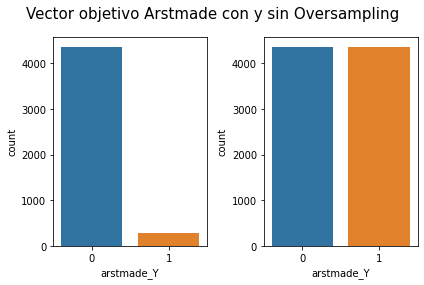

In [37]:
plt.suptitle('Vector objetivo Arstmade con y sin Oversampling', fontsize = 15)
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_arstmade)
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_oversamp_arstmade)
plt.tight_layout()

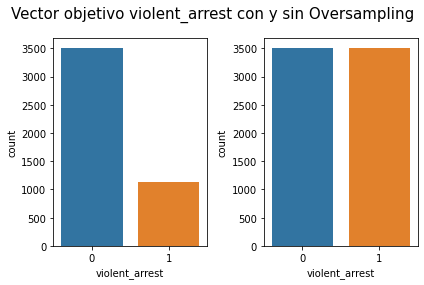

In [38]:
plt.suptitle('Vector objetivo violent_arrest con y sin Oversampling', fontsize = 15)
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_violent)
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_oversamp_violent)
plt.tight_layout()

### 4.2.1. Aplicando Multinomial Naive Bayes con SMOTE

In [39]:
NB_arstmade = GridSearchCV(estimator = MultinomialNB(),
                         param_grid = grid_params_NB,
                         scoring = 'accuracy',
                         cv = 10,
                         n_jobs = -1)
NB_arstmade.fit(X_train_arstmade, y_train_arstmade)
print('Los mejores parámetros son: ', NB_arstmade.best_params_)

Los mejores parámetros son:  {'alpha': 1}


In [40]:
NB_violent = GridSearchCV(estimator = MultinomialNB(),
                         param_grid = grid_params_NB,
                         scoring = 'accuracy',
                         cv = 10,
                         n_jobs = -1)
NB_violent.fit(X_train_violent, y_train_violent)
print('Los mejores parámetros son: ', NB_violent.best_params_)

Los mejores parámetros son:  {'alpha': 1}


***Comparativa con/sin oversampling***

In [41]:
# Violent sin oversampleo
violent_sin_over = MultinomialNB(alpha = 1).fit(X_train_violent, y_train_violent)
yhat_NB_violent = hp.reporte_metricas(violent_sin_over, X_test_violent, y_test_violent, 'Métricas con Multinomial Naive Bayes sin oversampling')

Métricas con Multinomial Naive Bayes sin oversampling: 

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3639
           1       0.47      0.49      0.48      1108

    accuracy                           0.75      4747
   macro avg       0.66      0.66      0.66      4747
weighted avg       0.76      0.75      0.75      4747



In [42]:
# Violent con oversampleo
violent_over = MultinomialNB(alpha = 1).fit(X_train_oversamp_violent, y_train_oversamp_violent)
yhat_NB_violent_over = hp.reporte_metricas(violent_over, X_test_violent, y_test_violent, 'Métricas con Multinomial Naive Bayes con oversampling')

Métricas con Multinomial Naive Bayes con oversampling: 

              precision    recall  f1-score   support

           0       0.88      0.71      0.78      3639
           1       0.41      0.67      0.51      1108

    accuracy                           0.70      4747
   macro avg       0.64      0.69      0.65      4747
weighted avg       0.77      0.70      0.72      4747



Viendo como afecta hacer oversample a los datos de entrenamiento nos podemos fijar en lo siguiente:
* Accuracy: Disminuyó en 5 puntos
* Precision clase 1: Disminuyó en 6 puntos
* Recall clase 1: Aumentó en 18 puntos

El oversampling, afectó en mayor medida al recall de la clase 1, pero nuestro objetivo es tener la **precision** más alta posible, que en el caso del oversampling empeoró en 5 puntos, **por lo que descartamos realizar oversampling en este dataset**.

In [43]:
# Arstmade sin oversampleo
arstmade = MultinomialNB(alpha = 1).fit(X_train_arstmade, y_train_arstmade)   
yhat_NB_violent = hp.reporte_metricas(arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Multinomial Naive Bayes Arstmade sin oversampling')

Métricas con Multinomial Naive Bayes Arstmade sin oversampling: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4438
           1       0.67      0.66      0.66       309

    accuracy                           0.96      4747
   macro avg       0.82      0.82      0.82      4747
weighted avg       0.96      0.96      0.96      4747



In [44]:
# Violent con oversampleo
arstmade_over = MultinomialNB(alpha = 1).fit(X_train_oversamp_arstmade, y_train_oversamp_arstmade)
yhat_NB_violent_over = hp.reporte_metricas(arstmade_over, X_test_arstmade, y_test_arstmade, 'Métricas con Multinomial Naive Bayes Arstmade con oversampling')

Métricas con Multinomial Naive Bayes Arstmade con oversampling: 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4438
           1       0.49      0.60      0.53       309

    accuracy                           0.93      4747
   macro avg       0.73      0.78      0.75      4747
weighted avg       0.94      0.93      0.94      4747



Viendo como afecta hacer oversample a los datos de entrenamiento nos podemos fijar en lo siguiente:
* Accuracy: Disminuyó en 3 puntos
* Precision clase 1: Disminuyó en 18 puntos
* Recall clase 1: Disminuyó en 6 puntos

Bajo el rendimiento del algoritmo en todos los aspectos, **por lo que descartamos hacer oversampleo con este dataset**.

## 4.3. Modelado de la predicción del evento 'Arstmade' (arresto)

### 4.3.1. Grillas de búsqueda hiperparámetros

In [45]:
grid_params_LR = [{'penalty': ['l2'],
                  'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'max_iter' : [100, 500, 1000, 2000,]
                  }]

In [46]:
grid_params_GB = [{'n_estimators' : [100, 500, 1000],
                   'learning_rate' : [0.01, 0.1, 0.5, 1, 5, 10],
                   'subsample' : np.linspace(0.1, 1, 5, endpoint = True, dtype = float)
                  }]

In [47]:
grid_params_NB = [{'alpha' : [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
                  }]

In [48]:
grid_params_SVC = [{'C': [0.1, 1, 10, 100, 1000],  
                  'gamma' : [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['rbf', 'poly']
                  }]

In [49]:
grid_params_DecTree = [{'criterion' : ['gini', 'entropy'],
                        'max_depth' : [1, 2, 3, 4],
                        'max_features' : ['sqrt', 'log2'],
                        'random_state' : [123]
                       }]

In [50]:
grid_params_RF = [{'n_estimators' : [50,80,100],
                   'criterion' : ['gini', 'entropy'],
                   'max_depth' : [2,3],
                   'max_features' : ['sqrt', 'log2'],
                   'random_state' : [123]
                   }]

***Logistic Regression 'Arstmade'***

In [51]:
LR_arstmade = GridSearchCV(estimator = LogisticRegression(),
                          param_grid = grid_params_LR,
                          scoring = 'precision',
                          cv = 10,
                          n_jobs = -1)
LR_arstmade.fit(X_train_arstmade, y_train_arstmade)
best_LR_arstmade = LR_arstmade.best_estimator_.fit(X_train_arstmade, y_train_arstmade)
yhat_LR_arstmade = hp.reporte_metricas(best_LR_arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Logistic Regression de Arstmade')
confusion_matrix(y_test_arstmade, yhat_LR_arstmade)

Métricas con Logistic Regression de Arstmade: 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4438
           1       0.87      0.49      0.62       309

    accuracy                           0.96      4747
   macro avg       0.92      0.74      0.80      4747
weighted avg       0.96      0.96      0.96      4747



array([[4415,   23],
       [ 159,  150]], dtype=int64)

In [52]:
accuracy_LR_arstmade, precision_LR_arstmade, recall_LR_arstmade = hp.get_metrics(y_test_arstmade, yhat_LR_arstmade)

***Gradient Boosting Classifier 'Arstmade'***

In [53]:
GB_arstmade = GridSearchCV(estimator = GradientBoostingClassifier(),
                          param_grid = grid_params_GB,
                          scoring = 'precision',
                          cv = 3,
                          n_jobs = -1)
GB_arstmade.fit(X_train_arstmade, y_train_arstmade)
best_GB_arstmade = GB_arstmade.best_estimator_.fit(X_train_arstmade, y_train_arstmade)
yhat_GB_arstmade = hp.reporte_metricas(best_GB_arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Multinomial Gradient Boosting Classifier de Arstmade')
confusion_matrix(y_test_arstmade, yhat_GB_arstmade)

Métricas con Multinomial Gradient Boosting Classifier de Arstmade: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4438
           1       0.89      0.46      0.60       309

    accuracy                           0.96      4747
   macro avg       0.93      0.73      0.79      4747
weighted avg       0.96      0.96      0.96      4747



array([[4421,   17],
       [ 168,  141]], dtype=int64)

In [54]:
accuracy_GB_arstmade, precision_GB_arstmade, recall_GB_arstmade = hp.get_metrics(y_test_arstmade, yhat_GB_arstmade)

***Multinomial Naive Bayes 'Arstmade'***

In [55]:
NB_arstmade = GridSearchCV(estimator = MultinomialNB(),
                          param_grid = grid_params_NB,
                          scoring = 'precision',
                          cv = 10,
                          n_jobs = -1)
NB_arstmade.fit(X_train_arstmade, y_train_arstmade)
best_NB_arstmade = NB_arstmade.best_estimator_.fit(X_train_arstmade, y_train_arstmade)
yhat_NB_arstmade = hp.reporte_metricas(best_NB_arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Multinomial Naive Bayes de Arstmade')
confusion_matrix(y_test_arstmade, yhat_NB_arstmade)

Métricas con Multinomial Naive Bayes de Arstmade: 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4438
           1       0.67      0.66      0.66       309

    accuracy                           0.96      4747
   macro avg       0.82      0.82      0.82      4747
weighted avg       0.96      0.96      0.96      4747



array([[4338,  100],
       [ 106,  203]], dtype=int64)

In [56]:
accuracy_NB_arstmade, precision_NB_arstmade, recall_NB_arstmade = hp.get_metrics(y_test_arstmade, yhat_NB_arstmade)

***Support Vector Classifier 'Arstmade'***

In [57]:
SVC_arstmade = GridSearchCV(estimator = SVC(),
                          param_grid = grid_params_SVC,
                          scoring = 'precision',
                          cv = 3,
                          n_jobs = -1)
SVC_arstmade.fit(X_train_arstmade, y_train_arstmade)
best_SVC_arstmade = SVC_arstmade.best_estimator_.fit(X_train_arstmade, y_train_arstmade)
yhat_SVC_arstmade = hp.reporte_metricas(best_SVC_arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Logistic Regression de Arstmade')
confusion_matrix(y_test_arstmade, yhat_SVC_arstmade)

Métricas con Logistic Regression de Arstmade: 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4438
           1       0.82      0.26      0.39       309

    accuracy                           0.95      4747
   macro avg       0.89      0.63      0.68      4747
weighted avg       0.94      0.95      0.93      4747



array([[4421,   17],
       [ 230,   79]], dtype=int64)

In [58]:
accuracy_SVC_arstmade, precision_SVC_arstmade, recall_SVC_arstmade = hp.get_metrics(y_test_arstmade, yhat_SVC_arstmade)

***Decision Tree Classifier 'Arstmade'***

In [59]:
DecTree_arstmade = GridSearchCV(estimator = DecisionTreeClassifier(),
                          param_grid = grid_params_DecTree,
                          scoring = 'precision',
                          cv = 3,
                          n_jobs = -1)
DecTree_arstmade.fit(X_train_arstmade, y_train_arstmade)
best_DecTree_arstmade = DecTree_arstmade.best_estimator_.fit(X_train_arstmade, y_train_arstmade)
yhat_DecTree_arstmade = hp.reporte_metricas(best_DecTree_arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Logistic Regression de Arstmade')
confusion_matrix(y_test_arstmade, yhat_DecTree_arstmade)

Métricas con Logistic Regression de Arstmade: 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4438
           1       0.82      0.49      0.62       309

    accuracy                           0.96      4747
   macro avg       0.89      0.74      0.80      4747
weighted avg       0.96      0.96      0.96      4747



array([[4405,   33],
       [ 157,  152]], dtype=int64)

In [60]:
accuracy_DecTree_arstmade, precision_DecTree_arstmade, recall_DecTree_arstmade = hp.get_metrics(y_test_arstmade, yhat_DecTree_arstmade)

***Random Forest Classifier 'Arstmade'***

In [61]:
RF_arstmade = GridSearchCV(estimator = RandomForestClassifier(),
                          param_grid = grid_params_RF,
                          scoring = 'precision',
                           cv = 3,
                          n_jobs = -1)
RF_arstmade.fit(X_train_arstmade, y_train_arstmade)
best_RF_arstmade = RF_arstmade.best_estimator_.fit(X_train_arstmade, y_train_arstmade)
yhat_RF_arstmade = hp.reporte_metricas(best_RF_arstmade, X_test_arstmade, y_test_arstmade, 'Métricas con Logistic Regression de Arstmade')
confusion_matrix(y_test_arstmade, yhat_RF_arstmade)

Métricas con Logistic Regression de Arstmade: 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4438
           1       1.00      0.05      0.09       309

    accuracy                           0.94      4747
   macro avg       0.97      0.52      0.53      4747
weighted avg       0.94      0.94      0.91      4747



array([[4438,    0],
       [ 295,   14]], dtype=int64)

In [62]:
accuracy_RF_arstmade, precision_RF_arstmade, recall_RF_arstmade = hp.get_metrics(y_test_arstmade, yhat_RF_arstmade)

## 4.3.1. Creando DataFrame de Métricas 'Arstmade'

In [63]:
names = ['Logistic Regression', 'Gradient Boosting', 'Multinomial Naive Bayes', 'SVC', 'Decision Tree Classifier', 'Random Forest']
accuracy_arstmade = [accuracy_LR_arstmade, accuracy_GB_arstmade, accuracy_NB_arstmade, accuracy_SVC_arstmade, accuracy_DecTree_arstmade, accuracy_RF_arstmade]
precision_arstmade = [precision_LR_arstmade, precision_GB_arstmade, precision_NB_arstmade, precision_SVC_arstmade, precision_DecTree_arstmade, precision_RF_arstmade]
recall_arstmade = [recall_LR_arstmade, recall_GB_arstmade, recall_NB_arstmade, recall_SVC_arstmade, recall_DecTree_arstmade, recall_RF_arstmade]

In [64]:
scores_arstmade = pd.DataFrame()

In [65]:
scores_arstmade['Algoritmo para arstmade'] = names
scores_arstmade['accuracy'] = accuracy_arstmade
scores_arstmade['precision_clase_1'] = precision_arstmade
scores_arstmade['recall_clase_1'] = recall_arstmade

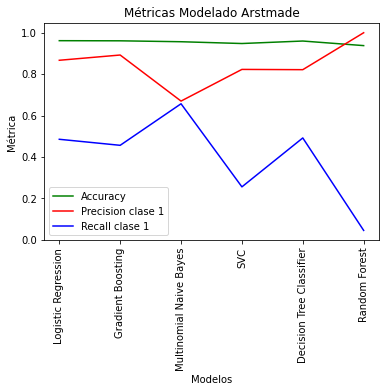

In [66]:
plt.plot(scores_arstmade['accuracy'], 'g', label = 'Accuracy');
plt.plot(scores_arstmade['precision_clase_1'], 'r', label = 'Precision clase 1');
plt.plot(scores_arstmade['recall_clase_1'], 'b', label = 'Recall clase 1');
plt.xticks(np.arange(6), scores_arstmade['Algoritmo para arstmade'], rotation = 90);
plt.xlabel('Modelos');
plt.ylabel('Métrica');
plt.title('Métricas Modelado Arstmade')
plt.legend();

In [67]:
scores_arstmade.style.background_gradient(cmap = 'Greens', low = 0, high = 1)

,Algoritmo para arstmade,accuracy,precision_clase_1,recall_clase_1
0,Logistic Regression,0.961660,0.867052,0.485437
1,Gradient Boosting,0.961028,0.892405,0.456311
2,Multinomial Naive Bayes,0.956604,0.669967,0.656958
3,SVC,0.947967,0.822917,0.255663
4,Decision Tree Classifier,0.959975,0.821622,0.491909
5,Random Forest,0.937855,1.000000,0.045307


***Conclusiones Modelado 'Arstmade'***

En cuanto al **accuracy** de los modelos, es muy similar en todos, entre 0.94 y 0.96, por lo que no nos dice mucho acerca del comportamiento, en donde tenemos que tener especial cuidado es en la **precision**, ya que el **costo de un Falso Positivo es alto**, y con esto nos referimos a que arrestar a una persona que no cometió un delito es algo **muy grave**.

Una vez aclarado lo de la precision, los dos mejores modelos son:
* **Logistic Regression**
* **Gradient Boosting**

Estos modelos son los que logran capturar de mejor manera los Verdaderos Positivos, sin bajar tanto el **recall**.

Por otra parte el modelo que mejor precision tiene, es Random Forest, pero tiene practicamente 0 de recall, lo cual lo hace muy desequilibrado.

Las métricas en detalle serán mostradas a continuación.


In [68]:
scores_arstmade.iloc[:2,:]

,Algoritmo para arstmade,accuracy,precision_clase_1,recall_clase_1
0,Logistic Regression,0.961660,0.867052,0.485437
1,Gradient Boosting,0.961028,0.892405,0.456311


In [69]:
print(' Logistic Regression Classification Report ARSTMADE\n' )
print(classification_report(y_test_arstmade, yhat_LR_arstmade))

 Logistic Regression Classification Report ARSTMADE

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4438
           1       0.87      0.49      0.62       309

    accuracy                           0.96      4747
   macro avg       0.92      0.74      0.80      4747
weighted avg       0.96      0.96      0.96      4747



c:\Users\gabo_\Desktop\portafolio\prueba2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


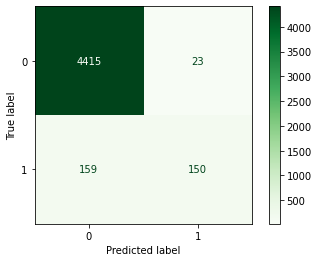

In [70]:
plot_confusion_matrix(best_LR_arstmade, X_test_arstmade, y_test_arstmade, cmap = 'Greens');

In [71]:
print("Gradient Boosting Classification Report ARSTMADE\n")
print(classification_report(y_test_arstmade, yhat_GB_arstmade))

Gradient Boosting Classification Report ARSTMADE

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4438
           1       0.89      0.46      0.60       309

    accuracy                           0.96      4747
   macro avg       0.93      0.73      0.79      4747
weighted avg       0.96      0.96      0.96      4747



c:\Users\gabo_\Desktop\portafolio\prueba2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


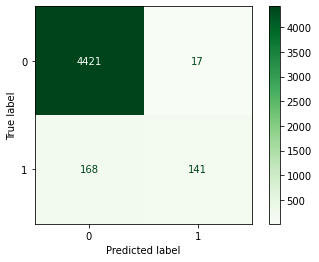

In [72]:
plot_confusion_matrix(best_GB_arstmade, X_test_arstmade, y_test_arstmade, cmap = "Greens");

Guardaremos los dos mejores modelos de clasificación 'Arstmade' en archivos Pickle, para preservarlos.

In [73]:
pickle.dump(best_LR_arstmade, open("model_LR_arstmade_gabo.sav", "wb"))
pickle.dump(best_GB_arstmade, open("model_GB_arstmade_gabo.sav", "wb"))

## 4.4. Modelado de la predicción del evento 'violent_arrest' (arresto violento)

***Logistic Regression'violen_arrest'***

In [74]:
LR_violent = GridSearchCV(estimator = LogisticRegression(),
                          param_grid = grid_params_LR,
                          scoring = "precision",
                          cv = 10,
                          n_jobs = -1)
LR_violent.fit(X_train_violent, y_train_violent)
best_LR_violent = LR_violent.best_estimator_.fit(X_train_violent, y_train_violent)
yhat_LR_violent = hp.reporte_metricas(best_LR_violent, X_test_violent, y_test_violent, "Métricas con Logistic Regression de Violent Arrest")
confusion_matrix(y_test_violent, yhat_LR_violent)

Métricas con Logistic Regression de Violent Arrest: 

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3639
           1       0.58      0.11      0.18      1108

    accuracy                           0.77      4747
   macro avg       0.68      0.54      0.53      4747
weighted avg       0.74      0.77      0.71      4747



array([[3552,   87],
       [ 988,  120]], dtype=int64)

In [75]:
accuracy_LR_violent, precision_LR_violent, recall_LR_violent = hp.get_metrics(y_test_violent, yhat_LR_violent)

***Gradient Boosting 'violent_arrest'***

In [76]:
GB_violent = GridSearchCV(estimator = GradientBoostingClassifier(),
                          param_grid = grid_params_GB,
                          scoring = "precision",
                          cv = 3,
                          n_jobs = -1)
GB_violent.fit(X_train_violent, y_train_violent)
best_GB_violent = GB_violent.best_estimator_.fit(X_train_violent, y_train_violent)
yhat_GB_violent = hp.reporte_metricas(best_GB_violent, X_test_violent, y_test_violent, "Métricas con Multinomial Gradient Boosting Classifier de Violent Arrest")
confusion_matrix(y_test_violent, yhat_GB_violent)

Métricas con Multinomial Gradient Boosting Classifier de Violent Arrest: 

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3639
           1       0.25      0.00      0.00      1108

    accuracy                           0.77      4747
   macro avg       0.51      0.50      0.43      4747
weighted avg       0.65      0.77      0.67      4747



array([[3636,    3],
       [1107,    1]], dtype=int64)

In [77]:
accuracy_GB_violent, precision_GB_violent, recall_GB_violent = hp.get_metrics(y_test_violent, yhat_GB_violent)

***Multinomial Naive Bayes 'violent_arrest'***

In [78]:
NB_violent = GridSearchCV(estimator = MultinomialNB(),
                          param_grid = grid_params_NB,
                          scoring = "precision",
                          cv = 10,
                          n_jobs = -1)
NB_violent.fit(X_train_violent, y_train_violent)
best_NB_violent = NB_violent.best_estimator_.fit(X_train_violent, y_train_violent)
yhat_NB_violent = hp.reporte_metricas(best_NB_violent, X_test_violent, y_test_violent, "Métricas con Multinomial Naive Bayes de Violent Arrest")
confusion_matrix(y_test_violent, yhat_NB_violent)

Métricas con Multinomial Naive Bayes de Violent Arrest: 

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3639
           1       0.47      0.49      0.48      1108

    accuracy                           0.75      4747
   macro avg       0.66      0.66      0.66      4747
weighted avg       0.76      0.75      0.75      4747



array([[3029,  610],
       [ 565,  543]], dtype=int64)

In [79]:
accuracy_NB_violent, precision_NB_violent, recall_NB_violent = hp.get_metrics(y_test_violent, yhat_NB_violent)

***Support Vector Classifier 'violent_arrest'***

In [80]:
SVC_violent = GridSearchCV(estimator = SVC(),
                          param_grid = grid_params_SVC,
                          scoring = "precision",
                          cv = 3,
                          n_jobs = -1)
SVC_violent.fit(X_train_violent, y_train_violent)
best_SVC_violent = SVC_violent.best_estimator_.fit(X_train_violent, y_train_violent)
yhat_SVC_violent = hp.reporte_metricas(best_SVC_violent, X_test_violent, y_test_violent, "Métricas con Logistic Regression de Violent Arrest")
confusion_matrix(y_test_violent, yhat_SVC_violent)

Métricas con Logistic Regression de Violent Arrest: 

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      3639
           1       0.54      0.10      0.18      1108

    accuracy                           0.77      4747
   macro avg       0.66      0.54      0.52      4747
weighted avg       0.72      0.77      0.71      4747



array([[3539,  100],
       [ 992,  116]], dtype=int64)

In [81]:
accuracy_SVC_violent, precision_SVC_violent, recall_SVC_violent = hp.get_metrics(y_test_violent, yhat_SVC_violent)

***Decision Tree Classifier 'violent_arrest'***

In [82]:
DecTree_violent = GridSearchCV(estimator = DecisionTreeClassifier(),
                          param_grid = grid_params_DecTree,
                          scoring = "precision",
                          cv = 3,
                          n_jobs = -1)
DecTree_violent.fit(X_train_violent, y_train_violent)
best_DecTree_violent = DecTree_violent.best_estimator_.fit(X_train_violent, y_train_violent)
yhat_DecTree_violent = hp.reporte_metricas(best_DecTree_violent, X_test_violent, y_test_violent, "Métricas con Logistic Regression de Violent Arrest")
confusion_matrix(y_test_violent, yhat_DecTree_violent)

Métricas con Logistic Regression de Violent Arrest: 

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      3639
           1       0.64      0.07      0.13      1108

    accuracy                           0.77      4747
   macro avg       0.71      0.53      0.50      4747
weighted avg       0.74      0.77      0.70      4747



array([[3592,   47],
       [1026,   82]], dtype=int64)

In [83]:
accuracy_DecTree_violent, precision_DecTree_violent, recall_DecTree_violent = hp.get_metrics(y_test_violent, yhat_DecTree_violent)

***Random Forest Classifier 'violent_arrest'***

In [84]:
RF_violent = GridSearchCV(estimator = RandomForestClassifier(),
                          param_grid = grid_params_RF,
                          scoring = "precision",
                          cv = 3,
                          n_jobs = -1)
RF_violent.fit(X_train_violent, y_train_violent)
best_RF_violent = RF_violent.best_estimator_.fit(X_train_violent, y_train_violent)
yhat_RF_violent = hp.reporte_metricas(best_RF_violent, X_test_violent, y_test_violent, "Métricas con Logistic Regression de Violent Arrest")
confusion_matrix(y_test_violent, yhat_RF_violent)

Métricas con Logistic Regression de Violent Arrest: 

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3639
           1       0.50      0.00      0.00      1108

    accuracy                           0.77      4747
   macro avg       0.63      0.50      0.43      4747
weighted avg       0.70      0.77      0.67      4747



array([[3638,    1],
       [1107,    1]], dtype=int64)

In [85]:
accuracy_RF_violent, precision_RF_violent, recall_RF_violent = hp.get_metrics(y_test_violent, yhat_RF_violent)

## 4.4.1. Creando DataFrame de Métricas 'violent_arrest'

In [86]:
accuracy_violent = [accuracy_LR_violent, accuracy_GB_violent, accuracy_NB_violent, accuracy_SVC_violent, accuracy_DecTree_violent, accuracy_RF_violent]
precision_violent = [precision_LR_violent, precision_GB_violent, precision_NB_violent, precision_SVC_violent, precision_DecTree_violent, precision_RF_violent]
recall_violent = [recall_LR_violent, recall_GB_violent, recall_NB_violent, recall_SVC_violent, recall_DecTree_violent, recall_RF_violent]

In [87]:
scores_violent = pd.DataFrame()
scores_violent["Algoritmo para Violent Arrest"] = names
scores_violent["accuracy"] = accuracy_violent
scores_violent["precision_clase_1"] = precision_violent
scores_violent["recall_clase_1"] = recall_violent

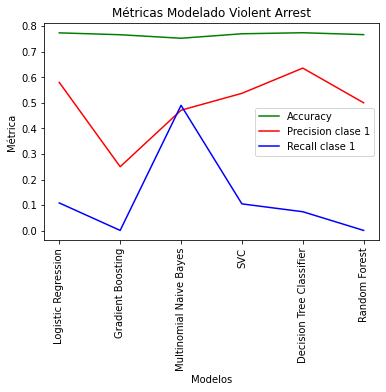

In [88]:
plt.plot(scores_violent["accuracy"], "g", label = "Accuracy");
plt.plot(scores_violent["precision_clase_1"], "r", label = "Precision clase 1");
plt.plot(scores_violent["recall_clase_1"], "b", label = "Recall clase 1");
plt.xticks(np.arange(6), scores_violent["Algoritmo para Violent Arrest"], rotation = 90);
plt.xlabel("Modelos");
plt.ylabel("Métrica");
plt.title("Métricas Modelado Violent Arrest")
plt.legend();

In [89]:
scores_violent.style.background_gradient(cmap = "Greens", low = 0, high = 1)

,Algoritmo para Violent Arrest,accuracy,precision_clase_1,recall_clase_1
0,Logistic Regression,0.773541,0.579710,0.108303
1,Gradient Boosting,0.766168,0.250000,0.000903
2,Multinomial Naive Bayes,0.752475,0.470945,0.490072
3,SVC,0.769960,0.537037,0.104693
4,Decision Tree Classifier,0.773963,0.635659,0.074007
5,Random Forest,0.766589,0.500000,0.000903


***Conclusiones Modelado 'violet_arrest'***

A nivel de accuracy están todos situados en los mismos niveles, entre 0.75 y 0.77, por lo que no nos sirve para decidir que modelo es mejor.

Pasando ahora a **precision y recall**, son resultados deficientes, en su mayoría por debajo de 0.5, por lo que no podemos obtener resultados consistentes, aun asi, si tenemos que escoger los 2 mejores, estos serían:
* **Multinomial Naive Bayes**
* **Logistic Regression**

Siendo Multinomial Naive Bayes el mejor, que a pesar de tener el accuracy más bajo (0.75), tiene un equilibrio entre **precision (0.47) y recall (0.49)**.

Sus métricas en detalle están a continuación.

In [90]:
scores_violent.iloc[[2,0] ,:]

,Algoritmo para Violent Arrest,accuracy,precision_clase_1,recall_clase_1
2,Multinomial Naive Bayes,0.752475,0.470945,0.490072
0,Logistic Regression,0.773541,0.579710,0.108303


In [91]:
print("Multinomial Naive Bayes Classification Report Violent Arrest\n")
print(classification_report(y_test_violent, yhat_NB_violent))

Multinomial Naive Bayes Classification Report Violent Arrest

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      3639
           1       0.47      0.49      0.48      1108

    accuracy                           0.75      4747
   macro avg       0.66      0.66      0.66      4747
weighted avg       0.76      0.75      0.75      4747



c:\Users\gabo_\Desktop\portafolio\prueba2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


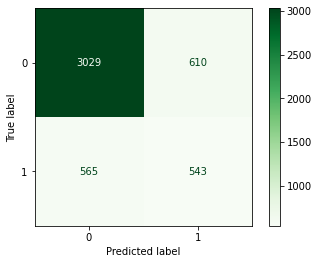

In [92]:
plot_confusion_matrix(best_NB_violent, X_test_violent, y_test_violent, cmap = "Greens");

In [93]:
print("Logistic Regresion Classification Report Violent Arrest\n")
print(classification_report(y_test_violent, yhat_LR_violent))

Logistic Regresion Classification Report Violent Arrest

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3639
           1       0.58      0.11      0.18      1108

    accuracy                           0.77      4747
   macro avg       0.68      0.54      0.53      4747
weighted avg       0.74      0.77      0.71      4747



c:\Users\gabo_\Desktop\portafolio\prueba2\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


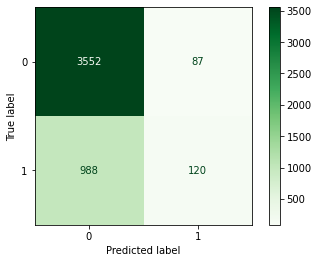

In [94]:
plot_confusion_matrix(best_LR_violent, X_test_violent, y_test_violent, cmap = "Greens");

Guardaremos los dos mejores modelos de clasificación 'violent_arrest' en archivos Pickle, para preservarlos.

In [95]:
pickle.dump(best_NB_arstmade, open("model_NB_violent_arrest_gabo.sav", "wb"))
pickle.dump(best_LR_arstmade, open("model_LR_violent_arrest_gabo.sav", "wb"))

# 5. Comentarios y conclusiones finales

Bien es sabido que en EEUU, la policía es racista a la hora de hacer detenciones o detenciones violentas, teniendo casos tan emblemáticos, como el de **George Floyd** el 25 de Marzo del 2020. Sus detenciones violentas son hechas principalmente a personas de raza negra, hispanos y latinos.

Es por esto, que este dataset posee estos mismos sesgos, por lo que **tenemos que tomar con pinzas** los resultados obtenidos aquí, recordemos que un algoritmo de machine learning estará sesgado, si la base de datos sobre la cual trabaja lo esta.

Por otra parte en cuanto a los datos y la calidad de estos como dijimos en un inicio, el 95.3% de las variables son categóricas, por lo que tal vez no sea el mejor dataset para realizar este tipo de análisis, las métricas obtenidas fueron muy pobres.